# Geospatial Processing

**Jupyter Kernel**:


* If you are in SageMaker Studio, make sure that you use the **PyTorch 1.10 Python 3.8 CPU Optimized** environment.
* Make sure that you are using one of the following instance types: `ml.m5.large` or `ml.g4dn.xlarge`.

**Role update**:

In order to use the [Amazon SageMaker Features for Geospatial ML](https://aws.amazon.com/sagemaker/geospatial/features/), please update the SageMaker Studio Execution Role as per the [Guideline](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/sagemaker-geospatial-roles.html). 
1. Print the execution role by running the cell below.

In [ ]:
import sagemaker

sagemaker.session.get_execution_role().split('/')[-1]

2. Copy the cell output, navigate to the [IAM console](https://console.aws.amazon.com/iam/) `Access management -> Roles` and search the role.

3. Attach the `AmazonSageMakerGeospatialFullAccess` permission policy.
4. Attach the following trust policy to the IAM role, which grants SageMaker principal permissions to assume the role.

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": [
                    "sagemaker-geospatial.amazonaws.com",
                    "sagemaker.amazonaws.com"
                ]
            },
            "Action": "sts:AssumeRole"
        }
    ]
}

```

**Run All**: 

* If you are in SageMaker Studio, you can choose the **Run All Cells** from the **Run** tab dropdown menu to run the entire notebook at once.

In [ ]:
# Install dependencies to use in this notebook.
!pip3 install -r ./utils/requirements.in -q

This solution relies on a config file to run the provisioned AWS resources. Run the cells below to generate that file.

In [ ]:
import boto3
import os
import json

In [ ]:
client = boto3.client('servicecatalog')
cwd = os.getcwd().split('/')
i= cwd.index('S3Downloads')
pp_name = cwd[i + 1]
pp = client.describe_provisioned_product(Name=pp_name)
record_id = pp['ProvisionedProductDetail']['LastSuccessfulProvisioningRecordId']
record = client.describe_record(Id=record_id)

keys = [ x['OutputKey'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
values = [ x['OutputValue'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
stack_output = dict(zip(keys, values))

with open(f'/root/S3Downloads/{pp_name}/stack_outputs.json', 'w') as f:
    json.dump(stack_output, f)

In [ ]:
sagemaker_config = json.load(open("stack_outputs.json"))

SOLUTION_BUCKET = sagemaker_config["SolutionS3Bucket"]
AWS_REGION = sagemaker_config["AWSRegion"]
SOLUTION_NAME = sagemaker_config["SolutionName"]
AWS_S3_BUCKET = sagemaker_config["S3Bucket"]
LIBRARY_VERSION = sagemaker_config["LibraryVersion"]

KEY_YIELD_CURVE = "data/raw/yield_curve_field_dt.csv"
SPATIAL_FILES_KEY = "data/spatial-files"
FIPS_STATS_KEY = "data/fips-stats/fips_county_stats.csv"
FIPS_POLYGONS_KEY = "data/fips-stats/geojson-counties-fips.json"
SENTINEL_2_SHAPEFILE_KEY = "data/sentinel-2-shapefiles"
CROPS_MASK_KEY = "data/crop_mask/raw"
METADATA_KEY = "data/geo-metadata/"
REQUEST_MANIFESTS_KEY = "request_manifests"

### Copy simulated data to S3

This solution uses both geospatial data and ground-level observations. We use ground-level observations from a publicly available [simulated dataset](https://data.mendeley.com/datasets/xs5nbm4w55/) of corn response to Nitrogen over thousands of fields and multiple years in Illinois.

For ease of access, we made the datasets available in an Amazon S3 bucket. Download the dataset from S3 in the following cells. 

In [ ]:
from sagemaker.s3 import S3Downloader

original_bucket = f"s3://{SOLUTION_BUCKET}-{AWS_REGION}/{LIBRARY_VERSION}/{SOLUTION_NAME}"
original_data = f"{original_bucket}/artifacts/data/"
current_location = f"s3://{AWS_S3_BUCKET}/data/"
print("original data:")
S3Downloader.list(original_data)

In [ ]:
if not S3Downloader.list(current_location):
    !aws s3 cp --recursive $original_data $current_location

### Set up the environment

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import datetime
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import seaborn as sns
import boto3
import io
import os
import s3fs
import spyndex
import re
import warnings
from shapely import wkb

import sagemaker
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput
from sagemaker.xgboost import XGBoost

from utils.helper_functions import (
    download_s3_folder,
    prepare_axis_request_manifests,
    spectral_indices_equation_prep
)

from utils.geospatial_functions import (
    return_tiled_ids_roi,
    prepare_roi
)

warnings.simplefilter('ignore')

%matplotlib inline

In [ ]:
# # Get the SageMaker session, SageMaker execution role, Region name, and S3 resource
sm_session = sagemaker.session.Session()
s3 = boto3.resource('s3')
s3_file = s3fs.S3FileSystem()
role = sagemaker.session.get_execution_role()

In [ ]:
# Define a few variables to use throughout the notebooks

EPSG = 'epsg:4326' # using the WGS84 latitude-longitude projection: "EPSG:4326"
REGION = '2-Central' # Illinois region
CROP_TYPE = 'corn' # crop type
YEAR = 2018 # crop year


BASE_DIR = "./src-geospatial"
BASE_JOB_PREFIX = "sagemaker-cyc"

Download spatial files locally.

In [ ]:
download_s3_folder(AWS_S3_BUCKET,SPATIAL_FILES_KEY, "tmp/spatial-files")
download_s3_folder(AWS_S3_BUCKET,SENTINEL_2_SHAPEFILE_KEY, "tmp/Sentinel-2-Shapefile-Index")

### Geospatial data preparation

Read the spatial files and the Federal Information Processing System (FIPS) county, state, code, and polygon data. Prepare the Region of Interest (RoI) shape files and save a temporary `zonal_fips_stats.geojson` file with the selected cell IDs (including geometry).
> **Note**: In order to reduce the execution time, few nearby tile grids are selected and the intersected polygons of cells and counties are passed forward to the subsequent geospatial processing steps.

In [ ]:
# Read spatial files
gpd_cells = gpd.read_file("tmp/spatial-files/cells_sf.shp")
gpd_cells = gpd_cells.to_crs(EPSG)

sentinel_tile_grids = gpd.read_file("tmp/Sentinel-2-Shapefile-Index/sentinel_2_index_shapefile.shx")
sentinel_tile_grids = sentinel_tile_grids.to_crs(EPSG)

# Read the FIPS geojson which maps counties, states, and codes
fips_stats = pd.read_csv(f"s3://{AWS_S3_BUCKET}/{FIPS_STATS_KEY}")
fips_stats = fips_stats[fips_stats.STNAME=='Illinois']

# Read the FIPS polygons
fips_polygons = gpd.read_file(f"s3://{AWS_S3_BUCKET}/{FIPS_POLYGONS_KEY}")
fips_polygons = fips_polygons.to_crs(EPSG)
fips_polygons["FIPS"] = fips_polygons["STATE"] + fips_polygons["COUNTY"]

# Filter by state: Illinois (17)
fips_polygons = fips_polygons[fips_polygons.STATE == '17']

### Return the RoI within the context of satellite tile grids

> **Note**: The number of tiles selected impacts the total execution time. We recommend selecting a maximum of three tiles for a demo, which takes about 2 hours to run.

In [ ]:
# return tiles
tile_ids = return_tiled_ids_roi(gpd_cells,
                                sentinel_tile_grids,
                                REGION)


tile_ids = ['15TYE','16TBK','15TXE']

# select tile grids of interest
tile_grid = sentinel_tile_grids[sentinel_tile_grids['Name'].isin(tile_ids)]

### Return the RoI and the list of the intersected FIPS data

FIPS - Federal Information Processing System (FIPS) Codes for States and Counties

* $\color{green}{\text{green polygons}}$ -- Counties
* $\color{orange}{\text{orange grid}}$ -- 10 x 10 km Cells
* large filled squares -- Satellite Tile Grids

In [ ]:
fips = prepare_roi(gpd_cells,
                   tile_grid, 
                   fips_stats, 
                   fips_polygons, 
                   REGION, 
                   AWS_S3_BUCKET)

In [ ]:
fips

### Prepare manifest files

Manifest files are created for each phenological stage. Manifest files include a `Time Range`, a list of `FIPS` and the `equations` of the vegetation spectral indices.

Select indices from the [vegetation spectral indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices#vegetation).

In [ ]:
SPECTRAL_INDICES = ['NDVI','EVI2','NDMI']

In [ ]:
# Retrieve the formulas for the selected spectral indices
spectral_indices_eqs = spectral_indices_equation_prep(SPECTRAL_INDICES)

In [ ]:
spectral_indices_eqs

### Corn phenology cycle

* Vegetative stages
    * VE – emergence, coleoptile breaks through the soil surface

    * V1 - one leaf collar is visible

    * V2 - second leaf collar is visible

    * V3 - third leaf collar is visible, plant begins to photosynthesize and rely on nodal root system

    * V4 - fourth leaf collar is visible

    * V5-V6 - fifth to sixth leaf collars are visible, growing point is above the soil surface, critical period of nitrogen uptake begins, and kernel row numbers are determined
    
    * V7-V(n) - seventh to nth leaf collars are visible, period of very rapid growth

    * VT – Tasselling – tassel is emerged, transitioning to reproductive phase
    
* Reproductive stages
    * R1 Silking – silks emerge from husks

    * R2 Blister – kernels are white on outside and inner fluid is clear

    * R3 Milk - kernels are yellow on the outside and inner fluid is milky-white

    * R4 Dough - milky inner fluid thickens from starch accumulation

    * R5 Dent – more than 50% of kernels are dented

    * R6 Physiological maturity – black layer formed

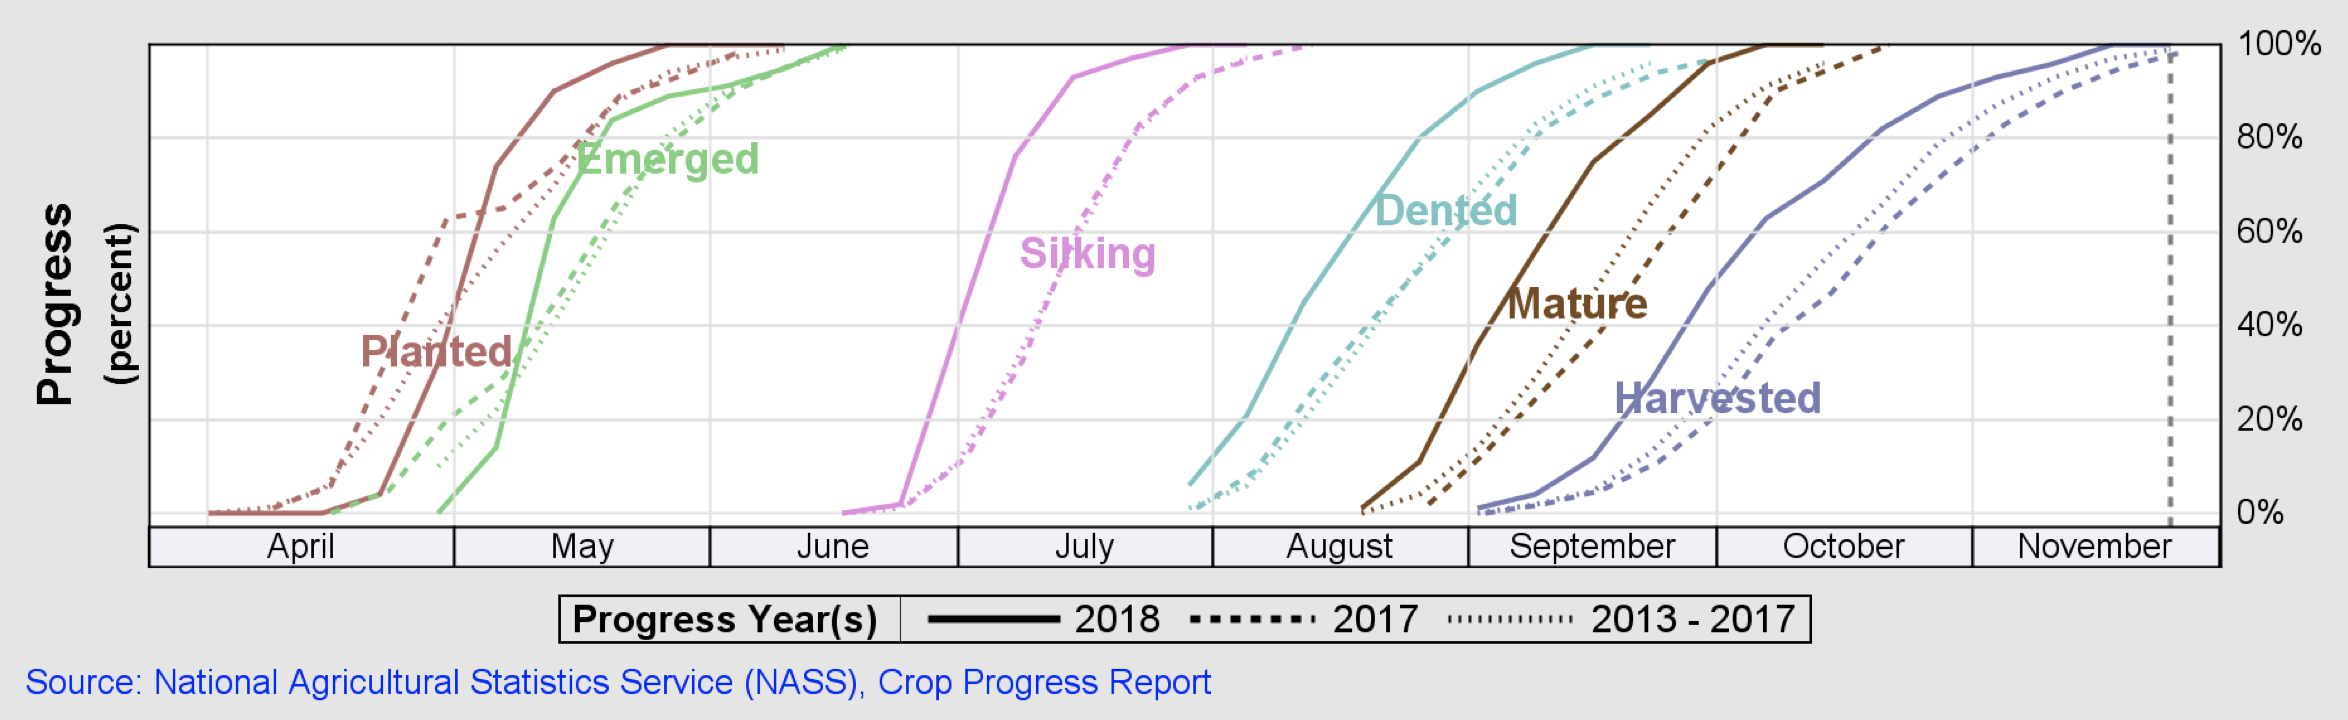

For our exercise, we divide the **corn** phenology cycle in three parts:

1. v5 - R1 ($\color{green}{\text{emerged}}$)
2. R1 - R4 ($\color{violet}{\text{silking}}$)
3. R5 , R6 ($\color{cyan}{\text{dented}}$, $\color{khaki}{\text{mature}}$)

In [ ]:
phenology_dic = {
    "emerged [v5 - R1]" : (f'{YEAR}-05-15T00:00:00Z',f'{YEAR}-06-15T00:00:00Z'),
    "silking -> doughing [R1 - R4]" : (f'{YEAR}-07-01T00:00:00Z', f'{YEAR}-08-01T00:00:00Z'),
    "dented -> mature [R5 - R6]" : (f'{YEAR}-08-15T00:00:00Z', f'{YEAR}-09-15T00:00:00Z')
}

In [ ]:
for stage in phenology_dic:

    print (f"Create manifest file for corn stage: {stage}")
    
    request_start_time = phenology_dic.get(stage)[0]
    request_end_time = phenology_dic.get(stage)[1]
    week = datetime.datetime.fromisoformat(request_start_time[:-1]).isocalendar()[1]
    manifest_filename = f"{REQUEST_MANIFESTS_KEY}/request-manifest-isoweek-{week}.json"

    prepare_axis_request_manifests(request_start_time,
                                   request_end_time,
                                   week,
                                   YEAR,
                                   fips,
                                   spectral_indices_eqs,
                                   manifest_filename,
                                   AWS_S3_BUCKET)

### Download crop masks

Download the crop masks corresponding to the selected phenology year from the National Agricultural Statistics Service (NASS) [CropScape - Cropland Data Layer](https://nassgeodata.gmu.edu/CropScape/) geodata.

Visualize the code by uncommenting the line in the following cell.

In [ ]:
#!pygmentize -g src-geospatial/download_crop_mask.py

A premade XGBoost [`FrameworkProcessor`](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) hosts the logic.

In [ ]:
download_crop_mask_processor = FrameworkProcessor(
        estimator_cls=XGBoost,  # Dummy class
        framework_version='1.2-2',  # is_ignored
        command=["python3"],
        instance_type="ml.m5.xlarge",
        instance_count=1,
        base_job_name=f"{BASE_JOB_PREFIX}-download-crop-masks",
        role=role,
        env={
            "OUTPUT_CROP_MASK_BUCKET_NAME": AWS_S3_BUCKET,
            "OUTPUT_CROP_MASK_PREFIX": f"{CROPS_MASK_KEY}",
        },
    )

fips_stats_input = ProcessingInput(
    source=f"s3://{AWS_S3_BUCKET}/{FIPS_STATS_KEY}",
    destination="/opt/ml/processing/input/fips_stats/",
)

In [ ]:
%%time

crop_masks_processor_args = download_crop_mask_processor.run(
    code="download_crop_mask.py",
    source_dir=BASE_DIR,
    inputs=[fips_stats_input],
    arguments=[
        "--starttime",
        f"{YEAR}-04-01",
        "--endtime",
        f"{YEAR}-10-01",
        "--fips-list",
        fips,
        "--crop-type",
        CROP_TYPE,
    ],
)

### Geospatial processing

This stage is using the newly released [Amazon SageMaker Features for Geospatial ML](https://aws.amazon.com/sagemaker/geospatial/) in order to import and transform large geospatial datasets with prebuilt operations.

With parallelized data distribution, manifest files are distributed across several instances using the `ShardedByS3Key` S3 data distribution type.

The `geospatial processing job` executes the following steps:

1. Run `CLOUD REMOVAL` Earth Observation Job
2. Run `GEOMOSAIC` Earth Observation Job for each phenological stage: 
    1. v5 - R1 ($\color{green}{\text{emerged}}$)
    2. R1 - R4 ($\color{violet}{\text{silking}}$)
    3. R5 , R6 ($\color{cyan}{\text{dented}}$, $\color{khaki}{\text{mature}}$)
3. Run `RESAMPLE` Earth Observation Job to resample tiles to 30m-by-30m resolution in order to match the crop mask resolution
4. Run `BANDMATH` Earth Observation Job to compute the spectral indices
5. Create metadata files

Visualize the code by uncommenting the line in the following cell.

In [ ]:
#!pygmentize -g src-geospatial/geospatial_processing.py

Clean-up the metadata files from previous runs

In [ ]:
!aws s3 rm --recursive s3://{AWS_S3_BUCKET}/{METADATA_KEY}

A premade XGBoost [`FrameworkProcessor`](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) hosts the logic.

In [ ]:
processing_ecr_image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=AWS_REGION,
    version="1.2-2",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)

In [ ]:
geo_processor = FrameworkProcessor(
    # The framework_version and estimator_cls arguments are ignored and the image URI is used instead.
    # We use framework_version and estimator_cls here as placeholders, since the arguments are required.
    estimator_cls=XGBoost,  # Dummy class
    framework_version='1.2-2',
    image_uri = processing_ecr_image_uri,
    instance_type="ml.m5.xlarge",
    instance_count=3,
    base_job_name=f"{BASE_JOB_PREFIX}-geospatial",
    command=["python3"],
    role=role,
    env={
        "COUNTIES_GEOJSON_FILE_PATH": (
                f"s3://{AWS_S3_BUCKET}/{FIPS_POLYGONS_KEY}"
        ),
        "REGION": AWS_REGION,
        "AXIS_ROLE_ARN": role
    },
)

> **Note**: The job takes approximately 2 hours to finish the geospatial processing depending on the selected Region Of Interest (RoI), as well as the selected time range.

In [ ]:
%%time

geo_requests_manifest_input = ProcessingInput(
    source=f"s3://{AWS_S3_BUCKET}/{REQUEST_MANIFESTS_KEY}",
    destination="/opt/ml/processing/input/axis_requests_manifests/",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="ShardedByS3Key",
)

step_args = geo_processor.run(
    code="geospatial_processing.py",
    source_dir=BASE_DIR,
    inputs=[geo_requests_manifest_input],
    arguments=[
        "--output-bucket",
        AWS_S3_BUCKET,
        "--metadata-key",
        METADATA_KEY
    ],
)

### Feature extraction

With parallelized data distribution, manifest files are distributed across several instances using the `ShardedByS3Key` S3 data distribution type.

The `feature extraction job` includes the following steps:

1. Merge bands into a single multi-channel mosaic
2. Crop mosaic using county's shape
3. Crop mask using county's shape
4. Reproject satellite image to use the crop mask's projection
5. Apply the crop mask and reproject the mosaic to the cell polygon CRS
6. Create zonal statistics by using the cell polygons (generated during the RoI step)

Visualize the code by uncommenting the line in the following cell.

In [ ]:
#!pygmentize -g src-geospatial/feature_extraction.py

A premade XGBoost [`FrameworkProcessor`](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) hosts the logic.

In [ ]:
# include RGB channels as well
spectral_indices_list = ['red','green','blue'] + SPECTRAL_INDICES


feature_extractor = FrameworkProcessor(
    estimator_cls=XGBoost,  # Dummy class
    framework_version='1.2-2',  # is_ignored
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=3,
    base_job_name=f"{BASE_JOB_PREFIX}-feature-extraction",
    role=role,
    env={
        "COUNTIES_GEOJSON_FILE_PATH": (
                f"s3://{AWS_S3_BUCKET}/{FIPS_POLYGONS_KEY}" # input of the FIPS polygons geojson file
        ),
        "INPUT_CROP_MASK_BUCKET_NAME": AWS_S3_BUCKET, # output bucket of the download mask step
        "INPUT_CROP_MASK_PREFIX": f"{CROPS_MASK_KEY}", # output key of the download mask step
        "OUTPUT_BUCKET_NAME": AWS_S3_BUCKET,
        "SPECTRAL_INDICES": ','.join(map(str, spectral_indices_list))
    },
)

metadata_mapping_input = ProcessingInput(
    source=f"s3://{AWS_S3_BUCKET}/{METADATA_KEY}",
    destination="/opt/ml/processing/input/sat_images_metadata_mapping/",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="ShardedByS3Key",
)

polygons_input = ProcessingInput(
    source=f"s3://{AWS_S3_BUCKET}/cell-polygons/",
    destination="/opt/ml/processing/input/polygons/"
)

In [ ]:
 %%time

step_args = feature_extractor.run(
    code="feature_extraction.py",
    source_dir=BASE_DIR,
    inputs=[metadata_mapping_input, polygons_input],
    arguments=[
        "--crop-type",
        f"{CROP_TYPE}"]
)

## Raster visualization

In [ ]:
!pip install rasterio scikit-image -q

In [ ]:
import rasterio
from matplotlib import pyplot
from rasterio import plot
from rasterio.plot import show
from skimage import exposure
from rasterio.windows import Window
from rasterio.plot import show_hist

from sagemaker.s3 import S3Downloader

In [ ]:
# Read mosaic paths (generated within the feature extraction step)
mosaics_path = f"s3://{AWS_S3_BUCKET}/crop-mosaic/"
mosaics_masked_path = f"s3://{AWS_S3_BUCKET}/crop-mosaic-masked/"

mosaics_files = S3Downloader.list(mosaics_path)
mosaics_masked_files = S3Downloader.list(mosaics_masked_path)

In [ ]:
# Raster window size
col_off = 128
row_off = 128
width = 512
height = 512

# County
FIPS = '17001'

In [ ]:
def extract_medata(file):
    """ Extracts medata from the file path"""
    
    metadata = file.split("/")[-1].split(".tif")[0].split("_")
    
    # Extract crop type
    crop_type = metadata[1]
    
    # Extract crop year
    year = metadata[2]
    
    # Extract county
    fips = metadata[-1]
    
    return crop_type, year, fips

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    
    array_min, array_max = array.min(), array.max()
    
    return ((array - array_min)/(array_max - array_min))

In [ ]:
# Select files as per the user-defined parameters
files_mosaic = [(file.split("/")[-2], file)
                for file in mosaics_files if extract_medata(file) == (CROP_TYPE, str(YEAR), FIPS)]
files_mosaic_masked = [(file.split("/")[-2], file)
                       for file in mosaics_masked_files if extract_medata(file) == (CROP_TYPE, str(YEAR), FIPS)]

### Visualize the RGB channels
Consecutive satellite visits (isoweeks) represent the following ***crop phenology stages***:

* v5 - R1 ($\color{green}{\text{emerged}}$)
* R1 - R4 ($\color{violet}{\text{silking}}$)
* R5 , R6 ($\color{cyan}{\text{dented}}$, $\color{khaki}{\text{mature}}$)

In [ ]:
# Iterate through the weeks
for idy in range(len(files_mosaic)):
    
    # Plot raster data
    fig, (axl, axr) = pyplot.subplots(1, 2, figsize=(15,7))
    
    # Read the RGB raster data
    src = rasterio.open(files_mosaic[idy][1])
    red = src.read(1, window=Window(col_off, row_off, width, height))
    green = src.read(2, window=Window(col_off, row_off, width, height))
    blue = src.read(3, window=Window(col_off, row_off, width, height))

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)

    # Create RGB natural color composite
    rgb = np.dstack((redn, greenn, bluen))
    
    # Apply intensity rescaling
    p2, p98 = np.percentile(rgb, (2,98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

    # Visualize the color composite
    axl.imshow(rgb)
    axl.set_title(f"band: RGB; week: {files_mosaic[idy][0]}; crop type: {CROP_TYPE}")
    
     # Read the RGB raster data
    src = rasterio.open(files_mosaic_masked[idy][1])
    red = src.read(1, window=Window(col_off, row_off, width, height))
    green = src.read(2, window=Window(col_off, row_off, width, height))
    blue = src.read(3, window=Window(col_off, row_off, width, height))

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)

    # Create RGB natural color composite
    rgb = np.dstack((redn, greenn, bluen))
    
    # Apply intensity rescaling
    p2, p98 = np.percentile(rgb, (2,98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

    # Visualize the color composite
    axr.imshow(rgb)
    axr.set_title(f"masked band: RGB; week: {files_mosaic_masked[idy][0]}; crop type: {CROP_TYPE}")

### Visualize spectral vegetation indices

Consecutive satellite visits (isoweeks) represent the following ***crop phenology stages***:
* v5 - R1 ($\color{green}{\text{emerged}}$)
* R1 - R4 ($\color{violet}{\text{silking}}$)
* R5 , R6 ($\color{cyan}{\text{dented}}$, $\color{khaki}{\text{mature}}$)

Visualize the spectral vegetation indices both with and without crop masks in the following cells.

Visualize the spectral vegetation indices without the crop mask.

In [ ]:
for idx, band in enumerate(spectral_indices_list[3:]):
    
    # Plot raster data 
    fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(20,7))
    
    # Read the raster data for the 1st visit
    src = rasterio.open(files_mosaic[0][1])
    src_masked = rasterio.open(files_mosaic_masked[0][1])

    show(src.read(idx+4, window=Window(col_off, row_off, width, height)),
         ax = ax1, 
         transform=src.transform,
         cmap = 'viridis',
         title=f"band: {band}; week: {files_mosaic[0][0]}; crop type: {CROP_TYPE}")
    
    # Read the raster data for the 2nd visit
    src = rasterio.open(files_mosaic[1][1])
    src_masked = rasterio.open(files_mosaic_masked[1][1])

    show(src.read(idx+4, window=Window(col_off, row_off, width, height)),
         ax = ax2, 
         transform=src.transform,
         cmap = 'viridis',
         title=f"band: {band}; week: {files_mosaic[1][0]}; crop type: {CROP_TYPE}")
    
    # Read the raster data for the 3rd visit
    src = rasterio.open(files_mosaic[2][1])
    src_masked = rasterio.open(files_mosaic_masked[2][1])

    show(src.read(idx+4, window=Window(col_off, row_off, width, height)),
         ax = ax3, 
         transform=src.transform,
         cmap = 'viridis',
         title=f"band: {band}; week: {files_mosaic[2][0]}; crop type: {CROP_TYPE}")

Visualize the spectral vegetation indices with the crop mask.

In [ ]:
for idx, band in enumerate(spectral_indices_list[3:]):
    
    # Plot raster data
    fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(20,7))
    
    # Read the raster data for the 1st visit
    src = rasterio.open(files_mosaic[0][1])
    src_masked = rasterio.open(files_mosaic_masked[0][1])

    show(src_masked.read(idx+4, window=Window(col_off, row_off, width, height)),
         ax = ax1, 
         transform=src.transform,
         cmap = 'viridis',
         title=f"masked band: {band}; week: {files_mosaic[0][0]}; crop type: {CROP_TYPE}")
    
    # Read the raster data for the 2nd visit
    src = rasterio.open(files_mosaic[1][1])
    src_masked = rasterio.open(files_mosaic_masked[1][1])

    show(src_masked.read(idx+4, window=Window(col_off, row_off, width, height)),
         ax = ax2, 
         transform=src.transform,
         cmap = 'viridis',
         title=f"masked band: {band}; week: {files_mosaic[1][0]}; crop type: {CROP_TYPE}")
    
    # Read the raster data for the 3rd visit
    src = rasterio.open(files_mosaic[2][1])
    src_masked = rasterio.open(files_mosaic_masked[2][1])

    show(src_masked.read(idx+4, window=Window(col_off, row_off, width, height)),
         ax = ax3, 
         transform=src.transform,
         cmap = 'viridis',
         title=f"masked band: {band}; week: {files_mosaic[2][0]}; crop type: {CROP_TYPE}")

### Next Steps

You can now open [01 Feature Engineering.ipynb](01%20Feature%20Engineering.ipynb) and follow the steps inside the notebook.